In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math
import os
import argparse

import matplotlib.pyplot as plt

from tqdm import tqdm

C:\Users\joska\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

In [6]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [7]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len
    # return loss.data[0] / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

In [11]:
# define args
filename = "shakespeare.txt"
n_epochs = 2000
model = "gru"
print_every = 100
hidden_size = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
shuffle = True
cuda = False


file, file_len = read_file(filename)

# Initialize models and start training
decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


Training for 2000 epochs...


  5%|▌         | 100/2000 [01:34<30:30,  1.04it/s]

 34s (100 5%) 1.7829]
When stice; lord have and heir art will thee; my dead?

QUEEN OF HALET:
Now not the daven his knived I 



 10%|█         | 200/2000 [03:09<29:46,  1.01it/s]

 9s (200 10%) 1.5739]
Whis own Looe,
And leave you wull that is a dead.

ARICET:
Where do the fleave and love!

CYORMESLA:
C 



 15%|█▌        | 300/2000 [04:47<28:34,  1.01s/it]

 47s (300 15%) 1.4931]
Wham, and a from lead;
The set fier with all shall got shall not party of the may deep the patience;
F 



 20%|██        | 400/2000 [06:26<26:37,  1.00it/s]

 26s (400 20%) 1.4419]
Whiles most.

ANGELO:
For this word, wilt I have hath one mark
To had be of pardon's ruchio's happer i 



 25%|██▌       | 500/2000 [08:06<25:21,  1.01s/it]

 6s (500 25%) 1.4376]
Whus you, sir: please thee it uncles
That I should not confe, do envious persenders but
That our left  



 30%|███       | 600/2000 [09:47<23:31,  1.01s/it]

 47s (600 30%) 1.4287]
Whe hath born heavy?

DUKE OF YORK:
Let him to my a.!

HASTINGS:
And I die me, such remember made
And  



 35%|███▌      | 700/2000 [11:26<21:47,  1.01s/it]

 26s (700 35%) 1.4108]
Why with me,
What any king than done, what I am looks.

MARCIUS:
This, go like the noble lips liked mo 



 40%|████      | 800/2000 [13:07<21:58,  1.10s/it]

 7s (800 40%) 1.3857]
What's embraced, sir,
To the world to a casied up and his very sendles.

HENRY BOLINGBROKE:
You loved  



 45%|████▌     | 900/2000 [14:48<18:24,  1.00s/it]

 47s (900 45%) 1.3921]
Which, from the call thee
Remembddelly'd Hortensio, matter that voice in my death,
in him, this is lif 



 50%|█████     | 1000/2000 [16:27<16:43,  1.00s/it]

 27s (1000 50%) 1.3902]
What.

ESCALUS:
In the father is not hanges so true.
Prove, that I say it hast man,
For that my heart  



 55%|█████▌    | 1100/2000 [18:07<15:31,  1.04s/it]

 7s (1100 55%) 1.3615]
Which God?

QUEEN MARGARET:
Well, be lose you blood?

SICINIUS:
Fear I will not both
To wear and becom 



 60%|██████    | 1200/2000 [19:48<13:26,  1.01s/it]

 48s (1200 60%) 1.3485]
Whey homest thou.

LUCENTIO:
Yet made him it and when that it should have death
Beforge a be one for d 



 65%|██████▌   | 1300/2000 [21:27<11:48,  1.01s/it]

 27s (1300 65%) 1.3528]
Whuster what an last with the
shepherd with the proceeds than this prisoner,
I cording so much after f 



 70%|███████   | 1400/2000 [23:06<09:34,  1.05it/s]

 6s (1400 70%) 1.3801]
Why, more?

LUCIO:
Ay, set brook after in my thine.

PAULINA:
No, be thou shadest
In very with Lord, o 



 75%|███████▌  | 1500/2000 [24:46<08:22,  1.00s/it]

 46s (1500 75%) 1.3678]
Whipper holder the serves?

CORIOLANUS:
Sweet hanges, though once.

HENRY BOLINGBROKE:
How! learn me t 



 80%|████████  | 1600/2000 [26:26<06:44,  1.01s/it]

 26s (1600 80%) 1.3508]
When but to cered more melted by the was able in the marriage
Be may person and mine, and in our dear  



 85%|████████▌ | 1700/2000 [28:03<05:03,  1.01s/it]

 3s (1700 85%) 1.3034]
What some that I have the hurchion
Made him doth so suits of this love his
sure, none and time and his 



 90%|█████████ | 1800/2000 [29:42<03:17,  1.01it/s]

 42s (1800 90%) 1.3655]
Whork him shall be dread upon us.

First Musician:
O, he did hastest blister love a blood.

CAMILLO:
H 



 95%|█████████▌| 1900/2000 [31:21<01:39,  1.00it/s]

 21s (1900 95%) 1.3123]
Whoer, my liege, hear me was pains,
Buty took thee the feaseful thing and was not from my face!
Condem 



100%|██████████| 2000/2000 [33:01<00:00,  1.01it/s]

 1s (2000 100%) 1.3353]
While see thee learn.

First Senator:
Stand his good lord with a rend ecrelets, and comes the cause,
W 

Saving...
Saved as shakespeare.pt


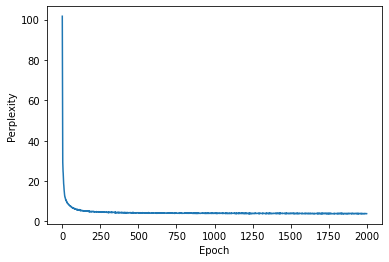

In [21]:

if cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

perplexities = []

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()


plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

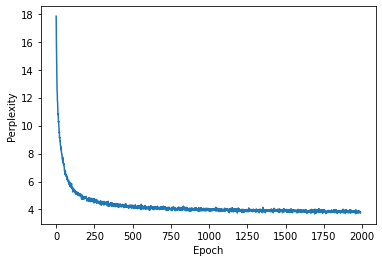

In [27]:
# if we ignore some of the first epochs we get a much clearer graph
plt.plot(perplexities[10:])
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

# PART 2

In [9]:
import string
import random

def randomString(len):
    s = ""
    for i in range(len):
        s = s + random.choice(string.printable)
    return s

In [26]:
decoder = torch.load("shakespeare.pt")

for i in range(5):
    prime_string = randomString(5)
    print("======Prime string:",prime_string,"======")
    print(generate(decoder, prime_str=prime_string))

======Prime string: l	@_. ======
l	@_.

DION:
Most wife giwl that they are brought to:
My life of Clais which does got bearing.

KING HENR
======Prime string: S)_5: ======
S)_5:
But in mon was a rock suddens so her patol.

KING EDWARD IV:
Since then; I for my lord, that both t
======Prime string: e-`.n ======
e-`.n ust forth graves,
Is for unless I'll passing the most beggars for them.

PETRUCHIO:
No hands ready 
======Prime string: Sr2Qv ======
Sr2QvK: I have in the publedily,
Or playery tears, and princes, I will hear her hour: be not
The fault's 
======Prime string: TT6IE ======
TT6IES:
And he hast I may not die, which come your oath
Comforty than her plague sleep.

Second Servingma


# PART 3

In [22]:
prime_string = "The"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: The
The rest, my lords of impeariness',
Disposition.'

FRIAR LAURENCE:
Now, sir, or that that patience o' t


In [23]:
prime_string = "What is"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: What is
What is her buse, good fair
That hath not our vain advantage of something
hand of king and closets my finge


In [24]:
prime_string = "Shall I give"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: Shall I give
Shall I give your lord;
And tell him place that here will thelp, gentlemen,
This comes out farther wild and mine


In [25]:
prime_string = "X087hNYB BHN BYFVuhsdbs"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: X087hNYB BHN BYFVuhsdbs
X087hNYB BHN BYFVuhsdbstart, lord impraced of my enemies.

First Senator:
What replainter'd of your word of me?

CLIFFORD:

